# EX11 폐렴아 기다려라!
****************

> **평가문항**
>- 1. 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.
>- 2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.
>- 3. 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.


## 1. 실험환경 Set-up

> $ mkdir -p ~/aiffel/chest_xray

> $ ln -s ~/data/ ~/aiffel/chest_xray

In [1]:
import os
import re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [8]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


## 2. 데이터 가져오기

In [9]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [10]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [11]:
# 정상 이미지와 폐렴 이미지를 구분
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1881_bacteria_4767.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person874_bacteria_2797.jpeg


In [12]:
# 이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있습니다.
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있습니다.
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1084
Pneumonia images count in training set: 3101


In [13]:
# tf.data는 tensorflow에서 학습시킬 때, 배치처리 작업을 보다 효율적으로 할 수 있도록 해줍니다.
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [14]:
# Train 데이터셋, validation 데이터셋 개수 확인을 해보겠습니다.
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [15]:
# 파일 경로에 'NORMAL'이나 'PNEUMONIA'가 포함되어 있기 때문에 
# 이를 이용해서 라벨 데이터를 만들어 주는 함수를 만들어 보겠습니다.

# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [16]:
# 이미지의 사이즈를 통일 시키고 ,
# GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄여봅시다.

# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [17]:
# train 데이터 셋과 validation 데이터 셋을 만듭니다.
# num_parallel_calls 파라미터에서 
# set-up에서 초기화 한 AUTOTUNE을 이용하면 더욱 빠르게 데이터를 처리해 줍니다.

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [18]:
# 이미지가 잘 리사이즈 되었는지, 그리고 라벨이 잘 들어가 있는지 확인해봅시다.

for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


In [19]:
# test 데이터셋도 만들어 보겠습니다.
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [20]:
# 좌우 반전 정도의 augmentation
# augmentation

def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## 3. 데이터 시각화

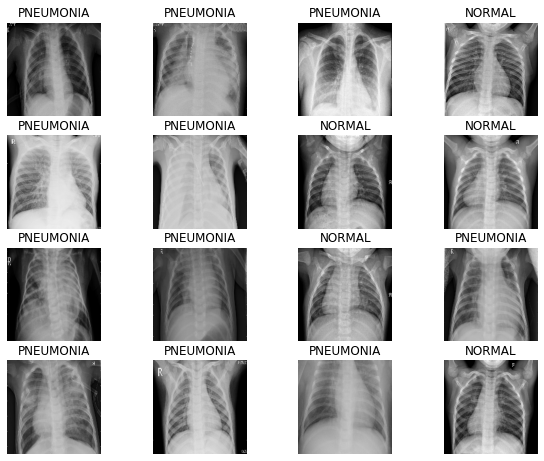

In [21]:
# train에 있는 batch 중 첫 번째 배치를 추출합니다. 
# 추출된 배치를 image와 label 데이터 셋으로 나눕니다.

# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## 4. CNN 모델링

- nomalization

In [22]:
# 먼저, Convolution block을 만듭니다.
# conv_block()의 구성은 Convolution을 두 번 진행하고 Batch Normalization을 통해서 
# Gradient vanishing, Gradient Exploding을 해결합니다. 그리고 Max Pooling을 합니다.

def conv_block_batch(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [23]:
def dense_block_batch(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization()
    ])
    
    return block

In [24]:
def build_model_batch():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block_batch(32),
        conv_block_batch(64),
        
        conv_block_batch(128),
        
        conv_block_batch(256),
        
        tf.keras.layers.Flatten(),
        dense_block_batch(512, 0.7),
        dense_block_batch(128, 0.5),
        dense_block_batch(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

- dropout

In [25]:
def conv_block_do(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [26]:
def dense_block_do(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [27]:
def build_model_do():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block_do(32),
        conv_block_do(64),
        
        conv_block_do(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block_do(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block_do(512, 0.7),
        dense_block_do(128, 0.5),
        dense_block_do(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

- augmentation + normalization + dropout

In [28]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [29]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [77]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(8, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(8, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## 5. 데이터 imbalance 처리

In [78]:
# 'Normal' 이미지에 사용할 weight
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
# 'Pneumonia' 이미지에 사용할 weight
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.93
Weight for PNEUMONIA: 0.67


## 6. 모델 훈련

- nomalization

In [32]:
with tf.device('/GPU:0'):
    model = build_model_batch()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [33]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 93s 235ms/step - loss: 0.2951 - accuracy: 0.8880 - precision: 0.9709 - recall: 0.8764 - val_loss: 0.6853 - val_accuracy: 0.7471 - val_precision: 0.7471 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 59s 228ms/step - loss: 0.1902 - accuracy: 0.9239 - precision: 0.9798 - recall: 0.9178 - val_loss: 1.1617 - val_accuracy: 0.7452 - val_precision: 0.7452 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 60s 230ms/step - loss: 0.1641 - accuracy: 0.9383 - precision: 0.9838 - recall: 0.9332 - val_loss: 0.1634 - val_accuracy: 0.9288 - val_precision: 0.9150 - val_recall: 0.9974
Epoch 4/25
261/261 [==============================] - 61s 236ms/step - loss: 0.1686 - accuracy: 0.9327 - precision: 0.9769 - recall: 0.9316 - val_loss: 0.0993 - val_accuracy: 0.9644 - val_precision: 0.9907 - val_recall: 0.9613
Epoch 5/25
261/261 [==============================] - 62s 238ms/step - loss: 0.1395 - accura

- dropout

In [34]:
with tf.device('/GPU:0'):
    model2 = build_model_do()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model2.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [35]:
with tf.device('/GPU:0'):
    history2 = model2.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 71s 231ms/step - loss: 0.4800 - accuracy: 0.7559 - precision: 0.8886 - recall: 0.7704 - val_loss: 0.9934 - val_accuracy: 0.7462 - val_precision: 0.7462 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 59s 227ms/step - loss: 0.2481 - accuracy: 0.8850 - precision: 0.9757 - recall: 0.8685 - val_loss: 0.5003 - val_accuracy: 0.7452 - val_precision: 0.7452 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 61s 233ms/step - loss: 0.1995 - accuracy: 0.9201 - precision: 0.9790 - recall: 0.9132 - val_loss: 0.1516 - val_accuracy: 0.9567 - val_precision: 0.9681 - val_recall: 0.9743
Epoch 4/25
261/261 [==============================] - 60s 229ms/step - loss: 0.1533 - accuracy: 0.9382 - precision: 0.9844 - recall: 0.9319 - val_loss: 0.1356 - val_accuracy: 0.9644 - val_precision: 0.9817 - val_recall: 0.9704
Epoch 5/25
261/261 [==============================] - 61s 232ms/step - loss: 0.1335 - accura

- augmentation + nomalization + dropout

In [58]:
with tf.device('/GPU:0'):
    model3 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model3.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [59]:
with tf.device('/GPU:0'):
    history3 = model3.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/35
418/418 [==============================] - 153s 224ms/step - loss: 0.4459 - accuracy: 0.7839 - precision: 0.9409 - recall: 0.7541 - val_loss: 0.7483 - val_accuracy: 0.7512 - val_precision: 0.7512 - val_recall: 1.0000
Epoch 2/35
418/418 [==============================] - 92s 221ms/step - loss: 0.2432 - accuracy: 0.9092 - precision: 0.9709 - recall: 0.9035 - val_loss: 0.1644 - val_accuracy: 0.9357 - val_precision: 0.9568 - val_recall: 0.9576
Epoch 3/35
418/418 [==============================] - 93s 223ms/step - loss: 0.2013 - accuracy: 0.9224 - precision: 0.9805 - recall: 0.9146 - val_loss: 0.1471 - val_accuracy: 0.9405 - val_precision: 0.9374 - val_recall: 0.9873
Epoch 4/35
418/418 [==============================] - 93s 223ms/step - loss: 0.1658 - accuracy: 0.9337 - precision: 0.9844 - recall: 0.9251 - val_loss: 0.1070 - val_accuracy: 0.9651 - val_precision: 0.9918 - val_recall: 0.9618
Epoch 5/35
418/418 [==============================] - 95s 227ms/step - loss: 0.1492 - accur

- augmentation + normalization + dropout + 에폭과 배치사이즈 조정 ( 정확도 85% 달성을 위한 )

In [79]:
with tf.device('/GPU:0'):
    model3 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model3.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [80]:
BATCH_SIZE = 16
EPOCHS = 20

In [81]:
with tf.device('/GPU:0'):
    history3 = model3.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/20
261/261 [==============================] - 73s 236ms/step - loss: 0.4548 - accuracy: 0.7948 - precision: 0.9417 - recall: 0.7705 - val_loss: 0.6037 - val_accuracy: 0.7462 - val_precision: 0.7462 - val_recall: 1.0000
Epoch 2/20
261/261 [==============================] - 62s 238ms/step - loss: 0.2766 - accuracy: 0.8932 - precision: 0.9633 - recall: 0.8904 - val_loss: 1.2682 - val_accuracy: 0.7471 - val_precision: 0.7471 - val_recall: 1.0000
Epoch 3/20
261/261 [==============================] - 61s 234ms/step - loss: 0.2203 - accuracy: 0.9184 - precision: 0.9739 - recall: 0.9158 - val_loss: 0.1485 - val_accuracy: 0.9385 - val_precision: 0.9271 - val_recall: 0.9961
Epoch 4/20
261/261 [==============================] - 61s 236ms/step - loss: 0.2091 - accuracy: 0.9198 - precision: 0.9815 - recall: 0.9101 - val_loss: 0.1907 - val_accuracy: 0.9356 - val_precision: 0.9759 - val_recall: 0.9369
Epoch 5/20
261/261 [==============================] - 62s 238ms/step - loss: 0.1955 - accura

## 7. 결과 확인과 시각화

- nomalization

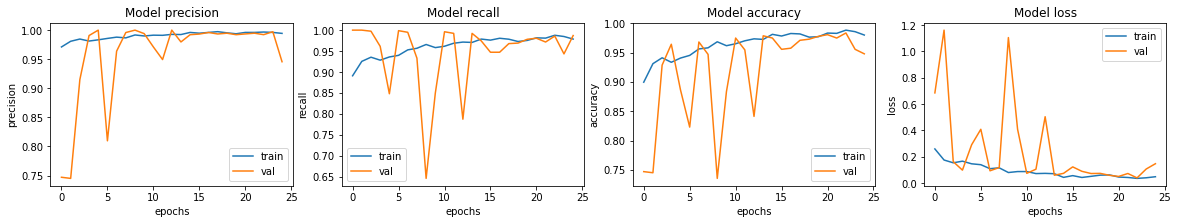

In [41]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [42]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 6s 145ms/step - loss: 1.0357 - accuracy: 0.7163 - precision: 0.6885 - recall: 0.9974
Loss: 1.035656213760376,
Accuracy: 0.7163461446762085,
Precision: 0.6884955763816833,
Recall: 0.9974358677864075


- dropout

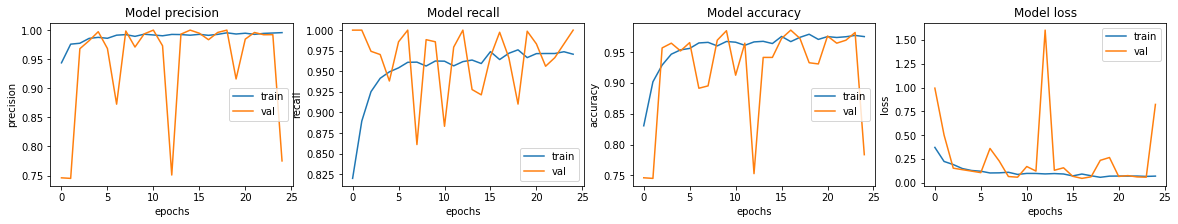

In [43]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history2.history[met])
    ax[i].plot(history2.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [44]:
loss, accuracy, precision, recall = model2.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 6s 150ms/step - loss: 4.3592 - accuracy: 0.6266 - precision: 0.6260 - recall: 1.0000
Loss: 4.359199523925781,
Accuracy: 0.6266025900840759,
Precision: 0.6260032057762146,
Recall: 1.0


- augmentation + normalization + dropout

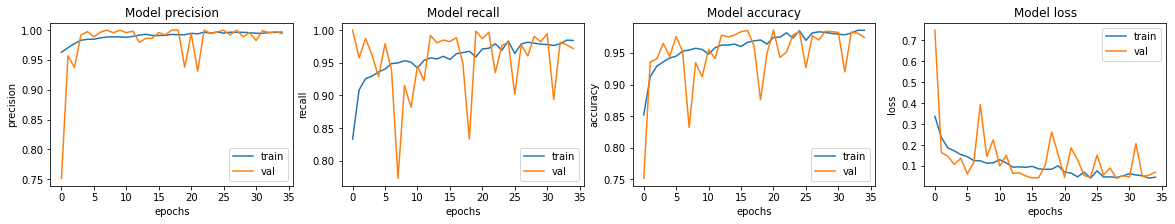

In [60]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history3.history[met])
    ax[i].plot(history3.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [61]:
loss, accuracy, precision, recall = model3.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 6s 156ms/step - loss: 1.0927 - accuracy: 0.7965 - precision: 0.7614 - recall: 0.9821
Loss: 1.0927343368530273,
Accuracy: 0.7964743375778198,
Precision: 0.7614313960075378,
Recall: 0.9820512533187866


- augmentation + normalization + dropout + 에폭과 배치사이즈 조정

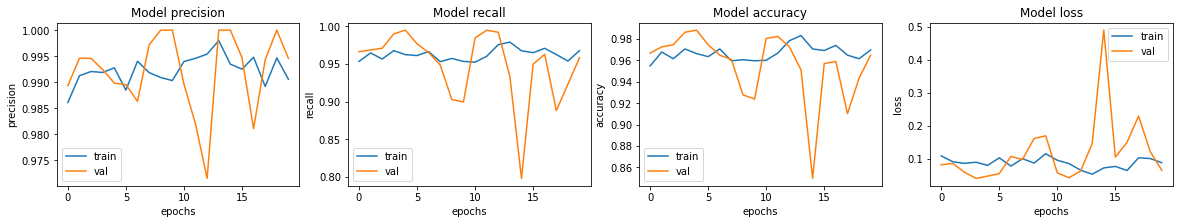

In [75]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history3.history[met])
    ax[i].plot(history3.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [76]:
loss, accuracy, precision, recall = model3.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 6s 148ms/step - loss: 0.9332 - accuracy: 0.7997 - precision: 0.7677 - recall: 0.9744
Loss: 0.9332165718078613,
Accuracy: 0.7996794581413269,
Precision: 0.7676767706871033,
Recall: 0.9743589758872986


   - augmentation + normalization + dropout + 에폭과 배치사이즈 조정(2)
    + batch size를 작게, Conv2D 값을 작게

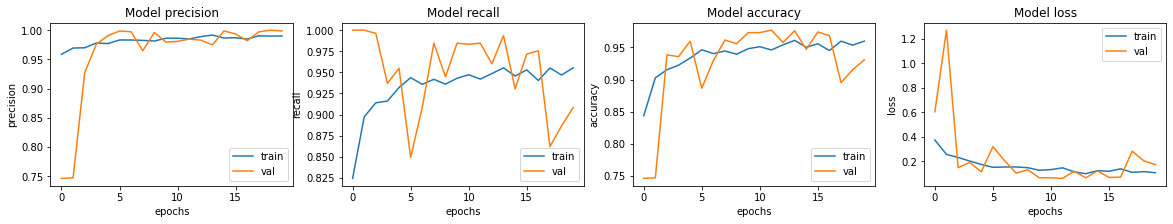

In [82]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history3.history[met])
    ax[i].plot(history3.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [83]:
loss, accuracy, precision, recall = model3.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 6s 152ms/step - loss: 0.4615 - accuracy: 0.8718 - precision: 0.8621 - recall: 0.9462
Loss: 0.4615144431591034,
Accuracy: 0.8717948794364929,
Precision: 0.8621495366096497,
Recall: 0.9461538195610046


***Recall 값은 비록 낮아지기는 했지만, Accuracy는 87퍼센트가 나왔다.***
****************

# 회고

- imbalance한 데이터를 학습시킬 때 학습효과가 떨어질 수 있으며, Weight balancing을 사용해서 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여해야한다.
- prepare_for_training()은 학습 데이터를 효율적으로 할 수 있도록 데이터를 변환 시키는 함수로서 정의한다고 한다.
- batch size를 작게할 수록 Accuracy가 좋아진다고 팀원에게 조언을 듣고, 30에서 10으로 해봤는데 별 차이가 없었다.아마 Conv2D같은 레이어를 값과 epochs가 모델에 대해서 적절하게 조정이 됐기 때문에 85퍼센트가 넘을 수 있었던것 같다.
- shuffle_buffer_size = 1000, eppchs : 20으로 고정하고, 다른 하이퍼 파라미터만 조절 했다.
- AUTO TUNE을 이용해서 더 빠르게 데이터를 처리한다고 하는데, 어떤게 빠르게 되는 것인지 정확하게 이해되지 않는다.

***솔직히 값을 계획적으로 바꿨다기 보다는 여러번의 시도를 통해서 Accuracy가 높게 나왔기 때문에 잘했다고는 생각이 들지 않는다. 아직까지 감이 오지 않는다.(시간이 비교적 오래 걸려서...더 하고 싶지만, 쉽지 않다.)***